# Predicting the next day stock value using LSTM and quantdata

In this model the input value is opening value of day and target value is the closing value of that same day.

In [1]:
#open the file which you want predict the stock price for...
#as we have minutely data with us we need firt create a dataframe which has data for day only..
#we did this because for minutely data, huge processing is required...


import pandas as pd
df = pd.read_csv("Infosys.csv",encoding = 'ISO-8859-1', index_col = 0)
df1 = df[df.Time.str.contains('09:28')]
df2 = df[df.Time.str.contains('15:28')]
print(len(df1),len(df2))

frame1 = [x for x in df1.Open]
frame2 = [x for x in df2.Close]
frame3 = [x for x in df1.Time]
frame4 = [x for x in df2.High]
frame5 = [x for x in df2.Low]
df = pd.DataFrame({
    "Open":frame1,
    "Close":frame2,
    "Time":frame3,
    "High":frame4,
    "Low":frame5
})

print(len(df))

945 945
945


In [3]:
import numpy as np
import pandas as pd
import math
import sklearn
import sklearn.preprocessing
import datetime
import os
import matplotlib.pyplot as plt
import tensorflow as tf

# split data in 80%/10%/10% train/validation/test sets
valid_set_size_percentage = 10 
test_set_size_percentage = 10 



In [4]:
# import all stock prices 

print (df.describe)

## number of different stocks
# print('\nnumber of different stocks: ', len(list(set(df.symbol))))
# print(list(set(df.symbol))[:10])

# df.tail()
# df.describe()

<bound method NDFrame.describe of        Close     High      Low     Open                      Time
0     474.89   475.00   474.75   479.02  2014-03-03T09:28:00+0530
1     474.88   475.12   474.71   475.12  2014-03-04T09:28:00+0530
2     478.00   478.00   477.69   477.75  2014-03-05T09:28:00+0530
3     479.51   479.71   479.14   480.47  2014-03-06T09:28:00+0530
4     466.71   467.00   466.44   478.44  2014-03-07T09:28:00+0530
5     459.63   459.88   459.45   461.10  2014-03-10T09:28:00+0530
6     459.66   459.88   459.64   456.88  2014-03-11T09:28:00+0530
7     459.40   459.50   459.04   461.29  2014-03-12T09:28:00+0530
8     419.82   419.84   419.55   423.67  2014-03-13T09:28:00+0530
9     423.99   424.00   423.78   423.70  2014-03-14T09:28:00+0530
10    418.29   418.75   418.25   423.73  2014-03-18T09:28:00+0530
11    409.05   409.09   409.02   410.04  2014-03-19T09:28:00+0530
12    412.89   413.10   412.88   411.48  2014-03-20T09:28:00+0530
13    414.02   414.58   413.75   413.75  2

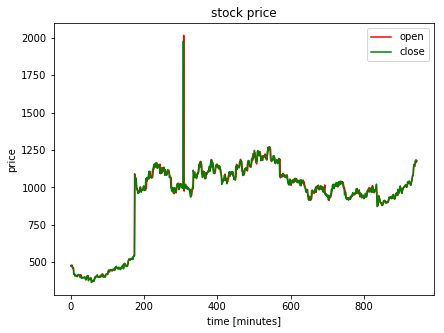

In [5]:
plt.figure(figsize=(15, 5));
plt.subplot(1,2,1);
plt.plot(df.Open.values, color='red', label='open')
plt.plot(df.Close.values, color='green', label='close')
# plt.plot(df.Low.values, color='blue', label='low')
# plt.plot(df.High.values, color='black', label='high')
plt.title('stock price')
plt.xlabel('time [minutes]')
plt.ylabel('price')
plt.legend(loc='best')
#plt.show()



In [6]:
# function for min-max normalization of stock
def normalize_data(df):
    min_max_scaler = sklearn.preprocessing.MinMaxScaler()
    df['Open'] = min_max_scaler.fit_transform(df.Open.values.reshape(-1,1))
    df['Close'] = min_max_scaler.fit_transform(df['Close'].values.reshape(-1,1))
    df['High'] = min_max_scaler.fit_transform(df.High.values.reshape(-1,1))
    df['Low'] = min_max_scaler.fit_transform(df['Low'].values.reshape(-1,1))
    return df

# function to create train, validation, test data given stock data and sequence length
def load_data(stock, seq_len):
    data_raw = stock.as_matrix() # convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - seq_len): 
        data.append(data_raw[index: index + seq_len])
    
    data = np.array(data);
    valid_set_size = int(np.round(valid_set_size_percentage/100*data.shape[0]));  
    test_set_size = int(np.round(test_set_size_percentage/100*data.shape[0]))
    train_set_size = data.shape[0] - (valid_set_size + test_set_size)
    print (valid_set_size,test_set_size)
    print (data.shape[0])
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_valid = data[train_set_size:train_set_size+valid_set_size,:-1,:]
    y_valid = data[train_set_size:train_set_size+valid_set_size,-1,:]
    
    x_test = data[train_set_size+valid_set_size:,:-1,:]
    y_test = data[train_set_size+valid_set_size:,-1,:]
    
    return [x_train, y_train, x_valid, y_valid, x_test, y_test]

# choose one stock
df_stock = df.copy()
df_stock.drop(['Time'],1,inplace=True)

cols = list(df_stock.columns.values)
print('df_stock.columns.values = ', cols)

# normalize stock
df_stock_norm = df_stock.copy()
df_stock_norm = normalize_data(df_stock_norm)

# create train, test data
seq_len = 20 # choose sequence length
x_train, y_train, x_valid, y_valid, x_test, y_test = load_data(df_stock_norm, seq_len)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_valid.shape = ',x_valid.shape)
print('y_valid.shape = ', y_valid.shape)
print('x_test.shape = ', x_test.shape)
print('y_test.shape = ',y_test.shape)

print(len(x_train),len(y_train))
print(len(x_test),len(y_test))
print(len(x_valid),len(y_valid))

df_stock.columns.values =  ['Close', 'High', 'Low', 'Open']
92 92
925
x_train.shape =  (741, 19, 4)
y_train.shape =  (741, 4)
x_valid.shape =  (92, 19, 4)
y_valid.shape =  (92, 4)
x_test.shape =  (92, 19, 4)
y_test.shape =  (92, 4)
741 741
92 92
92 92


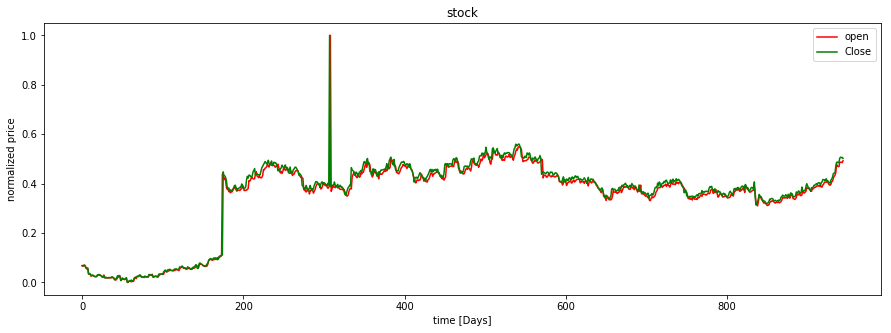

In [7]:
plt.figure(figsize=(15, 5));
plt.plot(df_stock_norm.Open.values, color='red', label='open')
plt.plot(df_stock_norm.Close.values, color='green', label='Close')
# plt.plot(df_stock_norm.Low.values, color='blue', label='low')
# plt.plot(df_stock_norm.High.values, color='black', label='high')
#plt.plot(df_stock_norm.volume.values, color='gray', label='volume')
plt.title('stock')
plt.xlabel('time [Days]')
plt.ylabel('normalized price')
plt.legend(loc='best')
plt.show()

In [8]:
## Basic Cell RNN in tensorflow

index_in_epoch = 0;
perm_array  = np.arange(x_train.shape[0])
np.random.shuffle(perm_array)

# function to get the next batch
def get_next_batch(batch_size):
    global index_in_epoch, x_train, perm_array   
    start = index_in_epoch
    index_in_epoch += batch_size
    
    if index_in_epoch > x_train.shape[0]:
        np.random.shuffle(perm_array) # shuffle permutation array
        start = 0 # start next epoch
        index_in_epoch = batch_size
        
    end = index_in_epoch
    return x_train[perm_array[start:end]], y_train[perm_array[start:end]]

# parameters
n_steps = seq_len-1 
n_inputs = 4
n_neurons = 200 
n_outputs = 4
n_layers = 2
learning_rate = 0.001
batch_size = 10
n_epochs = 100 
train_set_size = x_train.shape[0]
test_set_size = x_test.shape[0]

tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_outputs])

# # use Basic RNN Cell
# layers = [tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.elu)
#           for layer in range(n_layers)]

# use Basic LSTM Cell 
#layers = [tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons, activation=tf.nn.elu)
#          for layer in range(n_layers)]

#use LSTM Cell with peephole connections
layers = [tf.contrib.rnn.LSTMCell(num_units=n_neurons, 
                                 activation=tf.nn.leaky_relu, use_peepholes = True)
         for layer in range(n_layers)]

# use GRU cell
#layers = [tf.contrib.rnn.GRUCell(num_units=n_neurons, activation=tf.nn.leaky_relu)
#          for layer in range(n_layers)]
                                                                     
multi_layer_cell = tf.contrib.rnn.MultiRNNCell(layers)
rnn_outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons]) 
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])
outputs = outputs[:,n_steps-1,:] # keep only last output of sequence
                                              
loss = tf.reduce_mean(tf.square(outputs - y)) # loss function = mean squared error 
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate) 
training_op = optimizer.minimize(loss)
                                              
# run graph
with tf.Session() as sess: 
    sess.run(tf.global_variables_initializer())
    print (int(n_epochs*train_set_size/batch_size))
    for iteration in range(int(n_epochs*train_set_size/batch_size)):
        x_batch, y_batch = get_next_batch(batch_size) # fetch the next training batch 
        sess.run(training_op, feed_dict={X: x_batch, y: y_batch}) 
        if iteration % int(5*train_set_size/batch_size) == 0:
            mse_train = loss.eval(feed_dict={X: x_train, y: y_train}) 
            mse_valid = loss.eval(feed_dict={X: x_valid, y: y_valid}) 
            print('%.2f epochs: MSE train/valid = %.6f/%.6f'%(
                iteration*batch_size/train_set_size, mse_train, mse_valid))

    y_train_pred = sess.run(outputs, feed_dict={X: x_train})
    y_valid_pred = sess.run(outputs, feed_dict={X: x_valid})
    y_test_pred = sess.run(outputs, feed_dict={X: x_test})

7410
0.00 epochs: MSE train/valid = 0.135947/0.116027
4.99 epochs: MSE train/valid = 0.001688/0.000274
9.99 epochs: MSE train/valid = 0.001181/0.000775
14.98 epochs: MSE train/valid = 0.000987/0.000298
19.97 epochs: MSE train/valid = 0.001305/0.000969
24.97 epochs: MSE train/valid = 0.000787/0.000321
29.96 epochs: MSE train/valid = 0.000688/0.000236
34.95 epochs: MSE train/valid = 0.000821/0.000318
39.95 epochs: MSE train/valid = 0.000660/0.000131
44.94 epochs: MSE train/valid = 0.000623/0.000116
49.93 epochs: MSE train/valid = 0.000710/0.000443
54.93 epochs: MSE train/valid = 0.000568/0.000120
59.92 epochs: MSE train/valid = 0.000545/0.000155
64.91 epochs: MSE train/valid = 0.000525/0.000167
69.91 epochs: MSE train/valid = 0.000533/0.000191
74.90 epochs: MSE train/valid = 0.001023/0.000749
79.89 epochs: MSE train/valid = 0.000515/0.000102
84.89 epochs: MSE train/valid = 0.000509/0.000118
89.88 epochs: MSE train/valid = 0.000501/0.000102
94.87 epochs: MSE train/valid = 0.000558/0.00024

In [9]:
y_train.shape

(741, 4)

correct sign prediction for close - open price for train/valid/test: 0.51/0.55/0.66


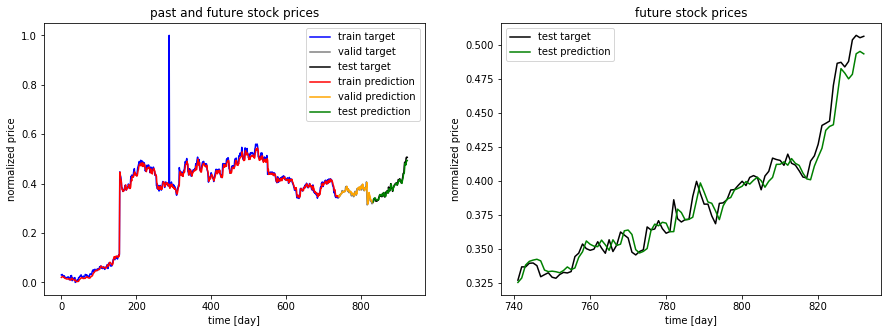

In [10]:
ft = 0 
# 0 = open, 1 = close, 2 = highest, 3 = lowest
## show predictions
plt.figure(figsize=(15, 5));
plt.subplot(1,2,1);

plt.plot(np.arange(y_train.shape[0]), y_train[:,ft], color='blue', label='train target')

plt.plot(np.arange(y_train.shape[0], y_train.shape[0]+y_valid.shape[0]), y_valid[:,ft],
         color='gray', label='valid target')

plt.plot(np.arange(y_train.shape[0]+y_valid.shape[0],
                   y_train.shape[0]+y_test.shape[0]+y_test.shape[0]),
         y_test[:,ft], color='black', label='test target')

plt.plot(np.arange(y_train_pred.shape[0]),y_train_pred[:,ft], color='red',
         label='train prediction')

plt.plot(np.arange(y_train_pred.shape[0], y_train_pred.shape[0]+y_valid_pred.shape[0]),
         y_valid_pred[:,ft], color='orange', label='valid prediction')

plt.plot(np.arange(y_train_pred.shape[0]+y_valid_pred.shape[0],
                   y_train_pred.shape[0]+y_valid_pred.shape[0]+y_test_pred.shape[0]),
         y_test_pred[:,ft], color='green', label='test prediction')

plt.title('past and future stock prices')
plt.xlabel('time [day]') 
plt.ylabel('normalized price')
plt.legend(loc='best');

plt.subplot(1,2,2);

plt.plot(np.arange(y_train.shape[0], y_train.shape[0]+y_test.shape[0]),
         y_test[:,ft], color='black', label='test target')

plt.plot(np.arange(y_train_pred.shape[0], y_train_pred.shape[0]+y_test_pred.shape[0]),
         y_test_pred[:,ft], color='green', label='test prediction')

plt.title('future stock prices')
plt.xlabel('time [day]')
plt.ylabel('normalized price')
plt.legend(loc='best');

corr_price_development_train = np.sum(np.equal(np.sign(y_train[:,1]-y_train[:,0]),
            np.sign(y_train_pred[:,1]-y_train_pred[:,0])).astype(int)) / y_train.shape[0]
corr_price_development_valid = np.sum(np.equal(np.sign(y_valid[:,1]-y_valid[:,0]),
            np.sign(y_valid_pred[:,1]-y_valid_pred[:,0])).astype(int)) / y_valid.shape[0]
corr_price_development_test = np.sum(np.equal(np.sign(y_test[:,1]-y_test[:,0]),
            np.sign(y_test_pred[:,1]-y_test_pred[:,0])).astype(int)) / y_test.shape[0]

print('correct sign prediction for close - open price for train/valid/test: %.2f/%.2f/%.2f'%(
    corr_price_development_train, corr_price_development_valid, corr_price_development_test))

### The green line tells us the prediction of the input data while dark line is the target value...